In [1]:

# General Utility imports
import os
import math
from pathlib import Path
import numpy as np

# Tensorflow model import
import tensorflow as tf
from keras import layers as tfkl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

# Tensorflow Privacy
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
import dp_accounting

# Matplotlib for visualization
import matplotlib.pyplot as plt

# Custom modules
from MySqueezeNet import SqueezeNet
import common


In [2]:
# HIGH PRIORITY
# TODO: Include the test data in the test set, this could be either the test set or the val and test set - maybe put the download data script in a seperate script
# TODO: Figure out a way to get a confusion matrix and classification report
# TODO: Experiment with bringing the rescaling back, try other scaling and standardization techniques
# TODO: look at ways of loading the data without image_dataset_from_directory
# LOW PRIORITY
# TODO: Look into using a cache for loaded images
# TODO: Investigate message "filling up shuffle buffer"
# TODO: experiment with techniques to make white stand out more in images
# TODO: experiment with other hyperparamaters
# TODO: Experiment with data augmentation

In [5]:
# Defing Hyperparamaters
EPOCHS = 100
BATCH_SIZE = 50
SEED = 42
IMAGE_SIZE = [265, 265]
DATA_DIR = Path(os.path.join("Datasets", "aptos2019-blindness-detection", "train"))
RESULTS_DIR = os.path.join("Results", "Centralized_DR")


NOISE_MULTIPLIER = 0.3
DIFFERENTIAL_PRIVACY = True
L2_NORM_CLIP = 1.5
LEARNING_RATE = 0.02
MICROBATCHES = 10




In [6]:
# create train and test datasets
image_count = len(list(DATA_DIR.glob("*/*.png")))

# Create a dataset from the filtered file paths
list_ds = tf.data.Dataset.list_files(str(DATA_DIR / "*/*"), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

class_names = np.array(sorted([item.name for item in DATA_DIR.glob("*")]))

# split the dataset into training and validation sets
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(f"Training data size: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Validation data size: {tf.data.experimental.cardinality(val_ds).numpy()}")

# map the image paths to the images and labels
train_ds = train_ds.map(lambda x: common.process_path(x, class_names, IMAGE_SIZE))
val_ds = val_ds.map(lambda x: common.process_path(x, class_names, IMAGE_SIZE))




Training data size: 2930
Validation data size: 732


In [14]:
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(265, 265, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
train_ds = common.configure_for_performance(train_ds, BATCH_SIZE)
val_ds = common.configure_for_performance(val_ds, BATCH_SIZE)

print(
    f"Training class distribution: {common.get_class_count(len(class_names), train_ds )}"
)
print(
    f"Validation class distribution: {common.get_class_count(len(class_names), val_ds )}"
)

In [5]:
data_prep = tf.keras.Sequential(
    [
        tfkl.Rescaling(1./255),
        tfkl.CenterCrop(224, 224)
    ]
)


data_augmentation = tf.keras.Sequential([data_prep, tfkl.RandomFlip("horizontal")])


# prepare the datasets
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
val_ds = val_ds.map(lambda x, y: (data_prep(x), y))

print(
    f"Post processing training class distribution: {common.get_class_count(len(class_names), train_ds )}"
)
print(
    f"Post processing Validation class distribution: {common.get_class_count(len(class_names), val_ds )}"
)



Post processing training class distribution: [1432  300  821  144  233]
Post processing Validation class distribution: [373  70 178  49  62]


In [6]:
# create the model
model = SqueezeNet(include_top=False, input_shape=(224, 224, 3))

# tf.keras.optimizers.experimental.SGD(momentum=0.9)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 111, 111, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 relu_conv1 (Activation)     (None, 111, 111, 64)         0         ['conv1[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 55, 55, 64)           0         ['relu_conv1[0][0]']          
                                                                                            

In [7]:
# simple early stopping
early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=20)

checkpoint = ModelCheckpoint(
    "best_model.h5", monitor="val_accuracy", mode="max", verbose=1, save_best_only=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint],
)

Epoch 1/100


59/59 [==============================] - ETA: 0s - loss: 1.3054 - accuracy: 0.4945
Epoch 1: val_accuracy improved from -inf to 0.50956, saving model to best_model.h5


c:\git_repos\Thesis\flowerEnv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


59/59 [==============================] - 71s 1s/step - loss: 1.3054 - accuracy: 0.4945 - val_loss: 1.0038 - val_accuracy: 0.5096
Epoch 2/100
59/59 [==============================] - ETA: 0s - loss: 0.9038 - accuracy: 0.6980
Epoch 2: val_accuracy improved from 0.50956 to 0.63115, saving model to best_model.h5
59/59 [==============================] - 60s 1s/step - loss: 0.9038 - accuracy: 0.6980 - val_loss: 0.9817 - val_accuracy: 0.6311
Epoch 3/100
59/59 [==============================] - ETA: 0s - loss: 0.8294 - accuracy: 0.7198
Epoch 3: val_accuracy did not improve from 0.63115
59/59 [==============================] - 61s 1s/step - loss: 0.8294 - accuracy: 0.7198 - val_loss: 0.9701 - val_accuracy: 0.5683
Epoch 4/100
59/59 [==============================] - ETA: 0s - loss: 0.7933 - accuracy: 0.7273
Epoch 4: val_accuracy did not improve from 0.63115
59/59 [==============================] - 60s 1s/step - loss: 0.7933 - accuracy: 0.7273 - val_loss: 1.0230 - val_accuracy: 0.5683
Epoch 5/100

In [8]:
best_model = load_model("best_model.h5")

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(len(loss))

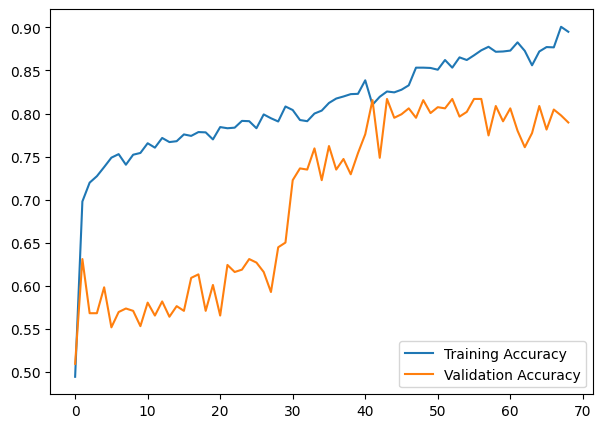

In [9]:
# PLot the dataset and save it
fig1, ax1 = plt.subplots(figsize=(7, 5))
ax1.plot(epochs_range, acc, label="Training Accuracy")
ax1.plot(epochs_range, val_acc, label="Validation Accuracy")
ax1.legend(loc="lower right")

fig1.savefig("Figures\\TrainingValidationAccuracy")

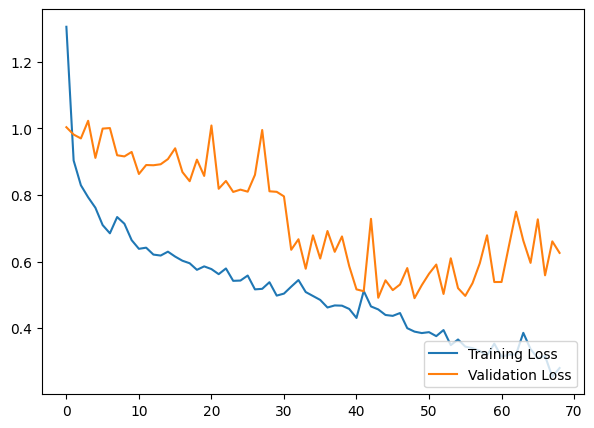

In [10]:
# PLot the dataset and save it
fig2, ax2 = plt.subplots(figsize=(7, 5))

ax2.plot(epochs_range, loss, label="Training Loss")
ax2.plot(epochs_range, val_loss, label="Validation Loss")
ax2.legend(loc="lower right")
fig2.savefig("Figures\\TrainingValidationLoss")

In [11]:
train_loss, train_acc = model.evaluate(train_ds, verbose=2)

print("\nTrain accuracy:", train_acc)

59/59 - 15s - loss: 0.2358 - accuracy: 0.9072 - 15s/epoch - 250ms/step

Train accuracy: 0.9071672558784485


In [12]:
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels
true_labels = []
predicted_labels = []

for images, labels in train_ds:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)


1/1 [==============================] - 0s 149ms/step
[[1424    7    1    0    0]
 [  11  233   52    4    0]
 [   2   28  736   11   44]
 [   1    1   11   72   59]
 [   0    6   30    8  189]]


In [13]:
from sklearn.metrics import classification_report

# Get the true labels and predicted labels
true_labels = []
predicted_labels = []

for images, labels in train_ds:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Create the classification report
report = classification_report(true_labels, predicted_labels)
print(report)


1/1 [==============================] - 0s 176ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1432
           1       0.86      0.80      0.83       300
           2       0.88      0.89      0.89       821
           3       0.75      0.51      0.61       144
           4       0.66      0.81      0.73       233

    accuracy                           0.91      2930
   macro avg       0.83      0.80      0.81      2930
weighted avg       0.91      0.91      0.91      2930



In [14]:
val_loss, val_acc = model.evaluate(val_ds, verbose=2)
print('\nValidation accuracy:', val_acc)


15/15 - 4s - loss: 0.6263 - accuracy: 0.7896 - 4s/epoch - 249ms/step

Validation accuracy: 0.7896174788475037


1/1 [==============================] - 0s 221ms/step


<Axes: >

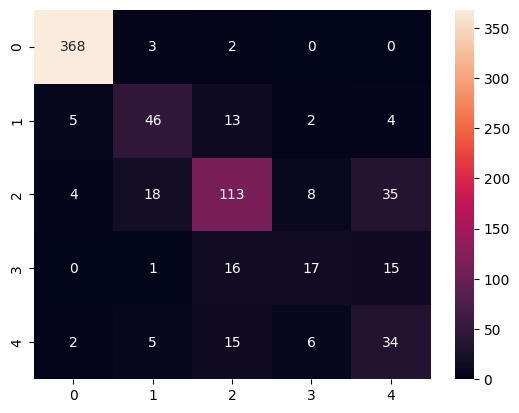

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels
true_labels = []
predicted_labels = []

for images, labels in val_ds:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d")





In [16]:
from sklearn.metrics import classification_report

# Get the true labels and predicted labels
true_labels = []
predicted_labels = []

for images, labels in val_ds:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Create the classification report
report = classification_report(true_labels, predicted_labels)
print(report)


1/1 [==============================] - 0s 166ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       373
           1       0.63      0.66      0.64        70
           2       0.71      0.63      0.67       178
           3       0.52      0.35      0.41        49
           4       0.39      0.55      0.45        62

    accuracy                           0.79       732
   macro avg       0.64      0.63      0.63       732
weighted avg       0.80      0.79      0.79       732

